In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torchaudio
from ae_model import CNNAutoencoder
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import datetime
import numpy as np

from custom_audio_dataset import BirdAudioDataset

PRETRAINED_PATH = "theta_run_birds/exp_dim10_files6_cropped/conv_autoencoder.pth"

# AUDIO_FILES = ["20210816T063139-0500_Rec.wav", "20210815T063139-0500_Rec.wav", "20210815T170000-0500_Rec.wav"]
AUDIO_FILES = ["20210816T063139-0500_Rec.wav"]
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050
CROPPED_MODE = True

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=(128 if CROPPED_MODE else 64)
)

bad = BirdAudioDataset(
    AUDIO_FILES, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device, crop_frequencies=CROPPED_MODE, num_seconds=60*60
)

Using cpu device
Original sample rate of audio is 44100 Hz
Loading 3600 seconds of audio...
Loaded 1 audio file(s)


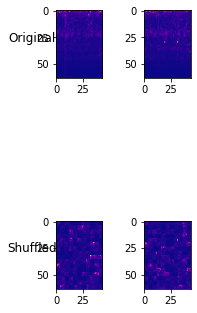

In [32]:


class ShufflePatches(object):
    def __init__(self, patch_size):
        self.ps = patch_size

    def __call__(self, x):
        # divide the batch of images into non-overlapping patches
        u = torch.nn.functional.unfold(x, kernel_size=self.ps, stride=self.ps, padding=0)
        # permute the patches of each image in the batch
        pu = torch.cat(
            [b_[:, torch.randperm(b_.shape[-1])][None, ...] for b_ in u], dim=0
        )
        # fold the permuted patches back together
        f = torch.nn.functional.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
        return f


transform = ShufflePatches(patch_size=4)

bad_subset = Subset(bad, range(0, 2))
dataloader = DataLoader(bad_subset, batch_size=1)

# Set up grayscale figure
fig_scale = 3
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(1 * fig_scale, 2 * fig_scale))
rows = ["Original", "Shuffled"]
for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, rotation=0, size="large")
fig.tight_layout()
plt.gray()

# Add subplot for each original spectrogram and shuffled
for i, (img, _) in enumerate(dataloader):
    
    print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
    
    img = img.to(device)
    transformed_img = transform(img)

    axes[0][i].imshow(img[0][0], cmap="plasma")
    axes[1][i].imshow(transformed_img[0][0], cmap="plasma")

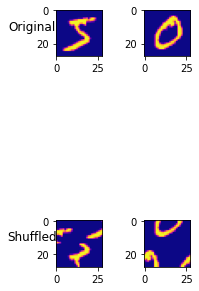

In [33]:
from torchvision.datasets import MNIST
from torchvision import transforms

transform = ShufflePatches(patch_size=14)

dataset = MNIST(root='MNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_subset = Subset(dataset, range(0, 2))
dataloader = DataLoader(mnist_subset, batch_size=1)

# Set up grayscale figure
fig_scale = 3
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(1 * fig_scale, 2 * fig_scale))
rows = ["Original", "Shuffled"]
for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, rotation=0, size="large")
fig.tight_layout()
plt.gray()

# Add subplot for each original spectrogram and shuffled
for i, (img, _) in enumerate(dataloader):
    
    print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
    
    img = img.to(device)
    transformed_img = transform(img)

    axes[0][i].imshow(img[0][0], cmap="plasma")
    axes[1][i].imshow(transformed_img[0][0], cmap="plasma")